In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy import integrate as si
import cmocean


plt.style.use("../paper.mplstyle")


In [2]:
# Perpendicular
def get_dataarray(
    df: pd.DataFrame, nfreq: int = 10001, method: str = "nearest", tol=1e-5, name=None
) -> xr.DataArray:
    """Extract DataArray from Nimrod's Excel sheet"""
    _x = np.array(df.iloc[3:, 2], dtype=float)
    _y = np.array(df.iloc[0, 4:41], dtype=float)
    _data = df.iloc[3:, 4:41]

    # data on experimental frequency grid
    da = xr.DataArray(_data.T, coords={"angle": _y, "frequency": _x}).dropna(
        dim="frequency"
    )

    # intepolate to regular grid
    _x = np.linspace(da.frequency.min(), da.frequency.max(), nfreq)
    da = da.interp(frequency=_x, method=method)

    da.data[da.data <= tol] = tol
    da.name = name

    return da

In [3]:
file = "GaN_(0001).xlsx"
df_para = pd.read_excel(file, sheet_name="Para_0001")
df_crss = pd.read_excel(file, sheet_name="Crss_0001")
da_para = get_dataarray(df_para, name="parallel")
da_crss = get_dataarray(df_crss, name="perpendicular")
ds_po = xr.merge([da_para, da_crss])
ds_po.to_netcdf("outfile.intensity_raman_po_001.h5")

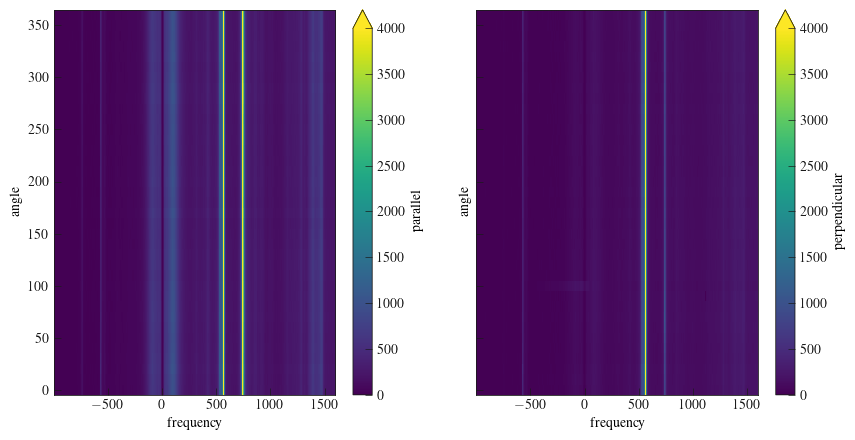

In [4]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

for ax, var in zip(axs, ds_po.data_vars):
    da = ds_po[var]
    vmin = da.data.min()
    vmax = da.data.max()
    kw = {"vmin": 0, "vmax": 4e3}
    norm = Normalize(**kw)
    xr.plot.imshow(da, ax=ax, norm=norm)

#   fig.savefig("plot_PO_10-10_linear.pdf")

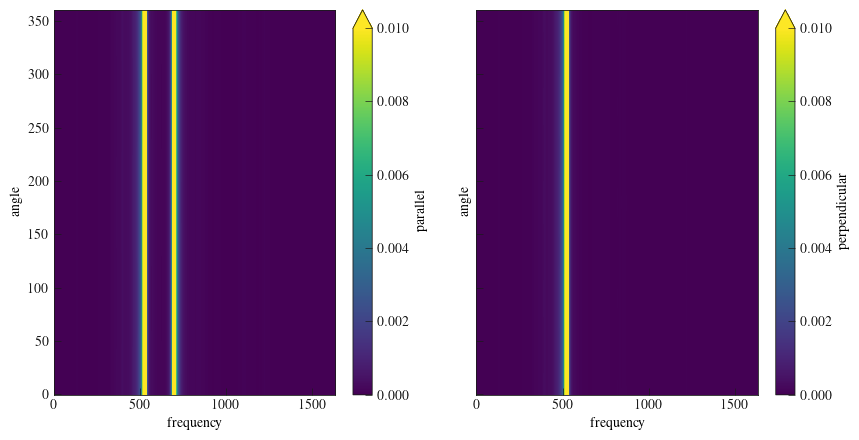

In [5]:
# theory
ds_theory = xr.load_dataset("outfile.raman_intensity_001_po.h5")

_ds = ds_theory

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

for ax, var in zip(axs, _ds.data_vars):
    da = _ds[var]
    vmin = da.data.min()
    vmax = da.data.max()
    kw = {"vmin": 0, "vmax": 0.01}
    norm = Normalize(**kw)
    xr.plot.imshow(da, ax=ax, norm=norm)

# fig.savefig("plot_PO_10-10_linear.pdf")

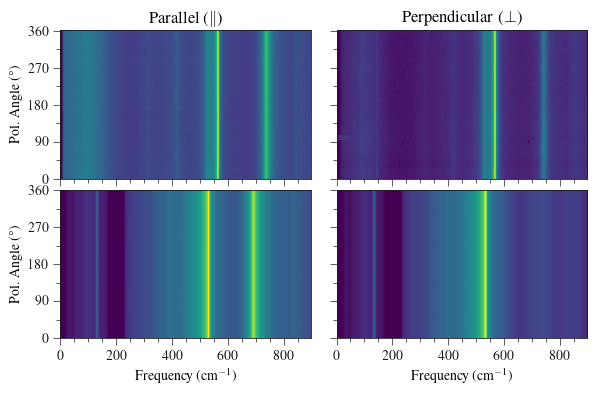

In [6]:
# both


ds0 = ds_po
ds1 = ds_theory

fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(6.8, 4), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.075)

xlim = (0, 900)

# exp
_ds = ds0

for ax, var in zip(axs[0], _ds.data_vars):
    da = _ds[var]
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    kw = {"vmin": 1e-3 * vmax, "vmax": 1 * vmax, "clip": True}
    norm = LogNorm(**kw)
    xr.plot.imshow(da, ax=ax, norm=norm, add_colorbar=False, add_labels=False)
    # ax.imshow(da.data, norm=norm) # , aspect="auto", origin="lower", extent=[0, 1000, 0, 90])
    ax.set_xlim(xlim)


# theory
_ds = ds1
for ax, var in zip(axs[1], _ds.data_vars):
    da = _ds[var]
    # da['frequency']  = 1.065 * da['frequency']
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    # normalize integral to 1
    kw = {"vmin": 1e-5 * vmax, "vmax": 1 * vmax, "clip": False}
    norm = LogNorm(**kw)
    xr.plot.imshow(da, ax=ax, norm=norm, add_colorbar=False, add_labels=False)
    # ax.imshow(da.data, norm=norm, aspect="auto", origin="lower", extent=[0, 1000, 0, 90])
    ax.set_xlim(xlim)

# labels
for ax in axs[:, 0]:
    ax.set_ylabel("Pol. Angle (°)")

for ax in axs[1, :]:
    ax.set_xlabel("Frequency (cm$^{-1}$)")

ax = axs[0, 0]
ax.set_title("Parallel ($\parallel$)")

ax = axs[0, 1]
ax.set_title("Perpendicular ($\perp$)")

for ax in axs.flatten():

    xticks = np.arange(*xlim, 100)
    xticks_minor = np.arange(*xlim, 50)
    ax.set_xticks(xticks_minor, minor=True)

    yticks = np.arange(0, 361, 90)
    ax.set_yticks(yticks, minor=False)

    yticks_minor = np.arange(0, 360, 45)
    ax.set_yticks(yticks_minor, minor=True)

    ax.tick_params(axis="both", direction="out", which="both")

fig.savefig("plot_PO_001.pdf")

In [7]:
def normalize(x, y, xmin=100, factor=0.95):
    mask=x>xmin
    _x = x[mask]
    _y = y[mask]
    y_int = si.trapezoid(_y-_y.min(), _x)
    y_out = y/y_int
    return y_out/y_out.max() * factor

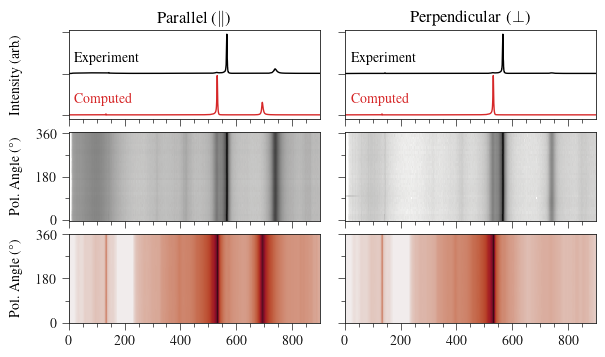

In [8]:
# with unpolarized spectra


ds0 = ds_po
ds1 = ds_theory

fig, axs = plt.subplots(ncols=2, nrows=3, sharey="row", figsize=(6.8, 3.8), sharex="col")
fig.subplots_adjust(wspace=0.1, hspace=0.15)

xlim = (0, 900)

# exp
_ds = ds0

for ax, var in zip(axs[1, :], _ds.data_vars):
    da = _ds[var]
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    kw = {"vmin": 1e-3 * vmax, "vmax": 1 * vmax, "clip": True}
    norm = LogNorm(**kw)
    xr.plot.imshow(da, ax=ax, norm=norm, add_colorbar=False, add_labels=False, cmap=cmocean.cm.gray_r)
    # ax.imshow(da.data, norm=norm) # , aspect="auto", origin="lower", extent=[0, 1000, 0, 90])

# unpolarized
for ax, var in zip(axs[0], _ds.data_vars):
    _da = _ds[var].sum(dim="angle")
    _x = _da.frequency
    _y = normalize(_x, _da)
    ax.plot(_x, _y+1, label=var, color="k", lw=1)


# theory
_ds = ds1
for ax, var in zip(axs[2], _ds.data_vars):
    da = _ds[var]
    # da['frequency']  = 1.065 * da['frequency']
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    # normalize integral to 1
    kw = {"vmin": 1e-5 * vmax, "vmax": 1 * vmax, "clip": False}
    norm = LogNorm(**kw)
    xr.plot.imshow(da, ax=ax, norm=norm, add_colorbar=False, add_labels=False, cmap=cmocean.cm.amp)
    # ax.imshow(da.data, norm=norm, aspect="auto", origin="lower", extent=[0, 1000, 0, 90])
    ax.set_xlim(xlim)

# unpolarized
for ax, var in zip(axs[0], _ds.data_vars):
    _da = _ds[var].sum(dim="angle")
    _x = _da.frequency
    _y = normalize(_x, _da)
    ax.plot(_x, _y, label=var, color="C3", lw=1)

# labels
for ax in axs[1:, 0]:
    ax.set_ylabel("Pol. Angle (°)", labelpad=10)

for ax in axs[1, :]:
    ax.set_xlabel("Frequency (cm$^{-1}$)")

ax = axs[0, 0]
ax.set_title("Parallel ($\parallel$)")

ax = axs[0, 1]
ax.set_title("Perpendicular ($\perp$)")

for ax in axs[1:, :].flatten():

    xticks = np.arange(*xlim, 100)
    xticks_minor = np.arange(*xlim, 50)
    ax.set_xticks(xticks_minor, minor=True)

    yticks = np.arange(0, 361, 180)
    ax.set_yticks(yticks, minor=False)

    yticks_minor = np.arange(0, 360, 90)
    ax.set_yticks(yticks_minor, minor=True)

    ax.tick_params(axis="both", direction="out", which="both")

for ax in axs[0].flatten():

    # ax.set_yticks(yticks, minor=False)

    # yticks_minor = np.arange(0, 360, 45)
    # ax.set_yticks(yticks_minor, minor=True)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([])

    ax.tick_params(axis="both", direction="out", which="both")

    # label
    ax.text(20, 1.3, "Experiment", color="k")
    ax.text(20, 0.3, "Computed", color="C3")

axs[0, 0].set_ylabel("Intensity (arb.)" , labelpad=25)

fig.savefig("plot_PO_001_total.pdf")

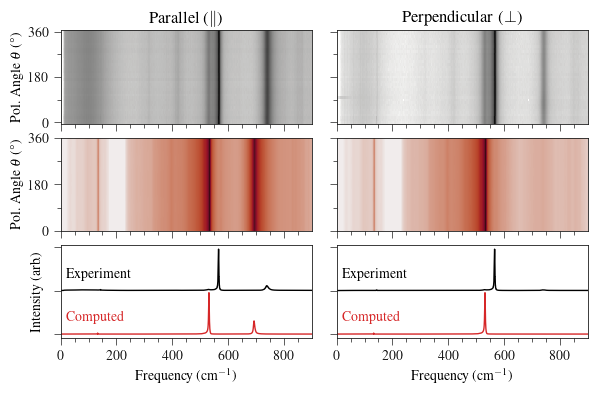

In [9]:
# with unpolarized spectra on top


ds0 = ds_po
ds1 = ds_theory

fig, axs = plt.subplots(ncols=2, nrows=3, sharey="row", figsize=(6.8, 4), sharex="col")
fig.subplots_adjust(wspace=0.1, hspace=0.15)

xlim = (0, 900)

# exp
_ds = ds0

for ax, var in zip(axs[0], _ds.data_vars):
    da = _ds[var]
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    kw = {"vmin": 1e-3 * vmax, "vmax": 1 * vmax, "clip": True}
    norm = LogNorm(**kw)
    xr.plot.imshow(da, ax=ax, norm=norm, add_colorbar=False, add_labels=False, cmap=cmocean.cm.gray_r)
    # ax.imshow(da.data, norm=norm) # , aspect="auto", origin="lower", extent=[0, 1000, 0, 90])

# unpolarized
for ax, var in zip(axs[2], _ds.data_vars):
    _da = _ds[var].sum(dim="angle")
    _x = _da.frequency
    _y = normalize(_x, _da)
    ax.plot(_x, _y+1, label=var, color="k", lw=1)


# theory
_ds = ds1
for ax, var in zip(axs[1], _ds.data_vars):
    da = _ds[var]
    # da['frequency']  = 1.065 * da['frequency']
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    # normalize integral to 1
    kw = {"vmin": 1e-5 * vmax, "vmax": 1 * vmax, "clip": False}
    norm = LogNorm(**kw)
    xr.plot.imshow(da, ax=ax, norm=norm, add_colorbar=False, add_labels=False, cmap=cmocean.cm.amp)
    # ax.imshow(da.data, norm=norm, aspect="auto", origin="lower", extent=[0, 1000, 0, 90])
    ax.set_xlim(xlim)

# unpolarized
for ax, var in zip(axs[2], _ds.data_vars):
    _da = _ds[var].sum(dim="angle")
    _x = _da.frequency
    _y = normalize(_x, _da)
    ax.plot(_x, _y, label=var, color="C3", lw=1)

# labels
for ax in axs[0:2, 0]:
    ax.set_ylabel("Pol. Angle $\\theta$ (°)")

for ax in axs[2, :]:
    ax.set_xlabel("Frequency (cm$^{-1}$)")

ax = axs[0, 0]
ax.set_title("Parallel ($\parallel$)")

ax = axs[0, 1]
ax.set_title("Perpendicular ($\perp$)")

for ax in axs[0:2, :].flatten():

    xticks = np.arange(*xlim, 100)
    xticks_minor = np.arange(*xlim, 50)
    ax.set_xticks(xticks_minor, minor=True)

    yticks = np.arange(0, 361, 180)
    ax.set_yticks(yticks, minor=False)

    yticks_minor = np.arange(0, 360, 90)
    ax.set_yticks(yticks_minor, minor=True)

    ax.tick_params(axis="both", direction="out", which="both")

for ax in axs[2].flatten():

    # ax.set_yticks(yticks, minor=False)

    # yticks_minor = np.arange(0, 360, 45)
    # ax.set_yticks(yticks_minor, minor=True)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([])

    ax.tick_params(axis="both", direction="out", which="both")

    # label
    ax.text(20, 1.3, "Experiment", color="k")
    ax.text(20, 0.3, "Computed", color="C3")

axs[2, 0].set_ylabel("Intensity (arb.)")

fig.savefig("plot_PO_001_total_reverese.pdf")

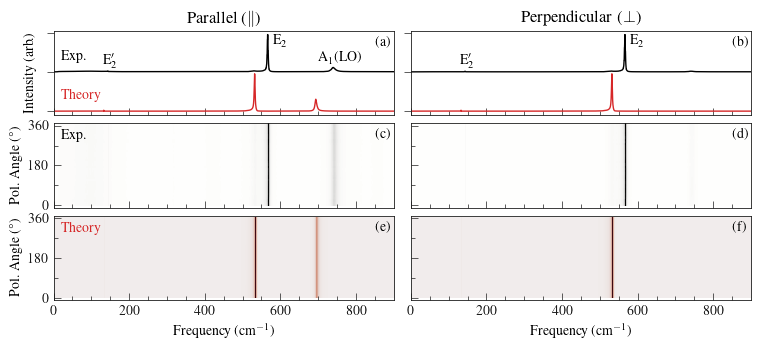

In [10]:
# with unpolarized spectra on semilogy


ds0 = ds_po
ds1 = ds_theory

fig, axs = plt.subplots(ncols=2, nrows=3, sharey="row", figsize=(9, 3.5), sharex="col")
fig.subplots_adjust(wspace=0.05, hspace=0.1)

xlim = (0, 900)

# exp
_ds = ds0

for ax, var in zip(axs[1, :], _ds.data_vars):
    da = _ds[var]
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    kw = {"vmin": 1e-3 * vmax, "vmax": 1 * vmax, "clip": True}
    norm = LogNorm(**kw)
    norm = Normalize(**kw)

    xr.plot.imshow(
        da,
        ax=ax,
        norm=norm,
        add_colorbar=False,
        add_labels=False,
        cmap=cmocean.cm.gray_r,
    )
    # ax.imshow(da.data, norm=norm) # , aspect="auto", origin="lower", extent=[0, 1000, 0, 90])

# unpolarized
for ax, var in zip(axs[0], _ds.data_vars):
    _da = _ds[var].sum(dim="angle")
    # _da = _da - _da.min()
    # _da = _da / _da.sum()
    _x = _da.frequency
    _y = normalize(_x, _da)
    # _y  = _da
    # ax.plot(_x, norm(_y), label=var, color="k", lw=1)
    ax.plot(_x, _y + 1, label=var, color="k", lw=1)


# theory
_ds = ds1
for ax, var in zip(axs[2], _ds.data_vars):
    da = _ds[var]
    # da['frequency']  = 1.065 * da['frequency']
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    # normalize integral to 1
    kw = {"vmin": 1e-5 * vmax, "vmax": 1 * vmax, "clip": False}
    norm = LogNorm(**kw)
    norm = Normalize(vmin=vmin, vmax=vmax)
    xr.plot.imshow(
        da, ax=ax, norm=norm, add_colorbar=False, add_labels=False, cmap=cmocean.cm.amp
    )
    # ax.imshow(da.data, norm=norm, aspect="auto", origin="lower", extent=[0, 1000, 0, 90])
    ax.set_xlim(xlim)

# unpolarized
for ax, var in zip(axs[0], _ds.data_vars):
    _da = _ds[var].sum(dim="angle")
    # _da = _da - _da.min()
    # _da = _da / _da.sum()
    _x = _da.frequency
    _y = normalize(_x, _da)
    # _y  = _da
    # ax.plot(_x, norm(_y), label=var, color="C3", lw=1)
    ax.plot(_x, _y, label=var, color="C3", lw=1)

# labels
for ax in axs[1:, 0]:
    ax.set_ylabel("Pol. Angle (°)")  # , labelpad=10)

for ax in axs[2, :]:
    ax.set_xlabel("Frequency (cm$^{-1}$)")

ax = axs[0, 0]
ax.set_title("Parallel ($\parallel$)")

ax = axs[0, 1]
ax.set_title("Perpendicular ($\perp$)")

for ax in axs[1:, :].flatten():

    ax.set_ylim(-10, 370)

    xticks = np.arange(*xlim, 100)
    xticks_minor = np.arange(*xlim, 50)
    ax.set_xticks(xticks_minor, minor=True)

    yticks = np.arange(0, 361, 180)
    ax.set_yticks(yticks, minor=False)

    yticks_minor = np.arange(0, 360, 90)
    ax.set_yticks(yticks_minor, minor=True)

    ax.tick_params(axis="both", direction="in", which="both")

for ax in axs[0].flatten():

    # ax.set_yticks(yticks, minor=False)

    # yticks_minor = np.arange(0, 360, 45)
    # ax.set_yticks(yticks_minor, minor=True)
    # ax.set_ylim(-10, 2)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([])

    ax.tick_params(axis="y", direction="out", which="both")

# label
ax = axs[0, 0]
ax.text(20, 1.3, "Exp.", color="k")
ax.text(20, 0.3, "Theory", color="C3")
ax = axs[1, 0]
ax.text(20, 340, "Exp.", va="top", color="k")
ax = axs[2, 0]
ax.text(20, 340, "Theory", va="top", color="C3")


axs[0, 0].set_ylabel("Intensity (arb.)")  #  , labelpad=25)


# put mode labels
ax = axs[0, 0]
ax.text(130, 1.2, "E$_2'$")
ax.text(580, 1.7, "E$_2$")
ax.text(700, 1.25, "A$_1$(LO)")
ax = axs[0, 1]
ax.text(130, 1.2, "E$_2'$")
ax.text(580, 1.7, "E$_2$")

labels = [f"({x})" for x in "a b c d e f".split()]
for _ax, _l in zip(axs.flatten(), labels):
    _ax.text(850, 0.82 * _ax.get_ylim()[1], _l)

fig.savefig("plot_PO_001_total_linear.pdf")